In [ ]:
!pip install keras-unet-collection

     |████████████████████████████████| 67 kB 2.6 MB/s 


In [ ]:
import tensorflow as tf
import os
import sys
import numpy as np
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow
from skimage.transform import resize
import random
import matplotlib.pyplot as plt
import time
import tensorflow_hub as hub
from google.colab import drive
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

In [ ]:
from keras_unet_collection import models, losses
from datetime import datetime 

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


resizing training images and masks


100%|██████████| 478/478 [03:29<00:00,  2.28it/s]


Done!


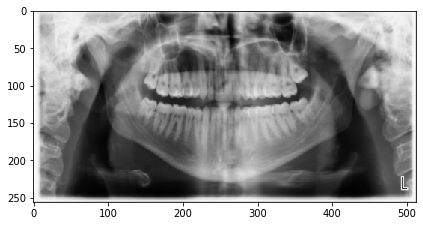

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


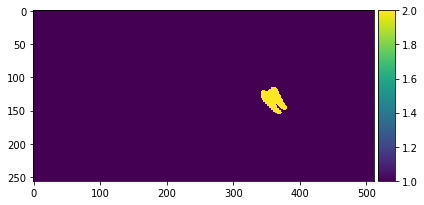

In [ ]:
#pre-processing and check all images and masks correctly read
IMG_WIDTH = 512
IMG_HEIGHT = 256
IMG_CHANNELS = 1
 
DATA_PATH = '/Path--/images/' # Training original images
Mask_path1= '/Path--/masks/'   # Segmentation Map



seed = 42
random.seed = seed
np.random.seed = seed
 
image_ids = next(os.walk(DATA_PATH))[2]

len(image_ids)
X = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)
Y = np.zeros((len(image_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print('resizing training images and masks')
for n, id_ in tqdm(enumerate(image_ids), total=len(image_ids)):
  try:
    path = DATA_PATH 
    img = imread(path+ id_)[:,:]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    for mask_file in next(os.walk(Mask_path1))[2]:
      if mask_file==id_:
        #print(Mask_path1 +  mask_file)
        mask_ = imread(Mask_path1 + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    Y[n] = mask
  except:
    print('error')

x_train=X 
y_train=Y

print('Done!')

image_x = random.randint(0, len(image_ids))
imshow(x_train[image_x])
plt.show()
imshow(np.squeeze(y_train[image_x])+1)
plt.show()

In [ ]:
#test images
TEST_PATH = '/Path--/images/'

test_ids = next(os.walk(TEST_PATH))[2]

len(test_ids)
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH), dtype=np.uint8)

sizes_test=[]
print('resizing training images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
  path = TEST_PATH 
  img = imread(path+ id_)[:,:]
  sizes_test.append([img.shape[0],img.shape[1]])
  img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
  X_test[n]=img 

In [ ]:
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 10

In [ ]:
help(models.att_unet_2d)

In [ ]:
model_att_unet = models.att_unet_2d((256, 512, 1), filter_num=[16,32,64, 128, 256], 
                           n_labels=num_labels, 
                           stack_num_down=2, stack_num_up=2, 
                           activation='ReLU', 
                           atten_activation='ReLU', attention='add', 
                           output_activation='Sigmoid', 
                           batch_norm=True, pool=True, unpool=True, 
                           backbone=None, weights=None, 
                           freeze_backbone=False, freeze_batch_norm=False, 
                           name='attunet')


model_att_unet.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['accuracy',losses.dice_coef])

print(model_att_unet.summary())

In [ ]:
start3 = datetime.now() 
callbacks= [tf.keras.callbacks.EarlyStopping(patience=5, monitor='loss')]#val_loss
att_unet_history = model_att_unet.fit(x_train, y_train, 
                    verbose=1,
                    batch_size = batch_size,
                    #validation_split=0.2, 
                    shuffle=False,
                    epochs=50, callbacks=callbacks)

stop3 = datetime.now()
#Execution time of the model 
execution_time_att_Unet = stop3-start3
print("Attention UNet execution time is: ", execution_time_att_Unet)

In [ ]:
t = time.time()
my_keras_model_filepath = '3rdm_att_UNet_50epochs_acc.h5'.format(int(t))
print(my_keras_model_filepath)
model_att_unet.save(my_keras_model_filepath)

3rdm_att_UNet_50epochs_acc.h5


In [ ]:
att_unet_history_df = pd.DataFrame(att_unet_history.history) 

In [ ]:
with open('att_unet_history_df.csv', mode='w') as f:
    att_unet_history_df.to_csv(f) 

In [ ]:
history = att_unet_history

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
#val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
#plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['dice_coef']
#acc = history.history['accuracy']
#val_acc = history.history['val_dice_coef']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Dice')
#plt.plot(epochs, val_acc, 'r', label='Validation Dice')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [ ]:
model = model_att_unet

In [ ]:
idx = random.randint(0, len(x_train))
preds_train = model_att_unet.predict(x_train[:int(x_train.shape[0]*0.9)], verbose=1)
preds_val = model_att_unet.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
preds_test = model_att_unet.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

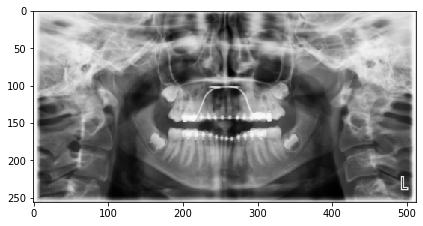

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


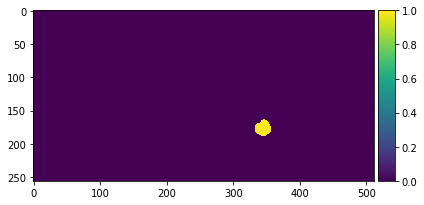

In [ ]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.show()
imshow(np.squeeze(preds_test_t[ix]))
plt.show()

#Support References:


*   https://github.com/bnsreenu/python_for_microscopists/blob/master/227_mito_segm_using_models_from_Keras_Unet_collection.py
*   https://pypi.org/project/keras-unet-collection/
*   https://github.com/yingkaisha/keras-unet-collection/blob/main/examples/user_guide_models.ipynb
*   https://www.youtube.com/watch?v=ZoJuhRbzEiM






